Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
from gfacts.preprocessing import preprocess_dataset

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
X = X.drop(columns=['fnlwgt','education'])
num_features = X._get_numeric_data().columns.to_list()

X['income'] = np.where((X['income'] == ' <=50K'), 0, 1)
df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [24]:
num_features

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

## Model training and test

In [3]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 5.23 s
Wall time: 11.9 s


C:\Users\dinos\anaconda3\envs\work\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11147
           1       0.72      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.80      0.76      0.78     14653
weighted avg       0.84      0.85      0.85     14653



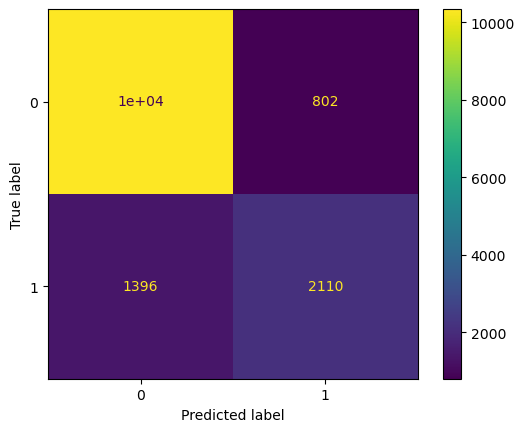

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp=0.03,
    missing_subgroup_val="Unknown",
    drop_infeasible=False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|█████████████████████████████████████████████████████████████████████████████| 1681/1681 [00:05<00:00, 321.99it/s]

Computing correctenesses for all valid if-thens.



100%|██████████████████████████████████████████████████████████████████████████████| 8173/8173 [01:41<00:00, 80.81it/s]

Number of if-thens: 8173


In [8]:
# ### Uncomment if you wish to load rules object from disk

# import dill

# with open("rulesAdultFairTest.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [9]:
# ### Uncomment if you wish to save rules object on disk

# import dill

# with open("rulesAdultFairTest.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If Workclass =  Private, education-num = 13, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 3.92% covered
		Make marital-status =  Married-civ-spouse, relationship =  Husband with correctness 12.57%.
		Make education-num = 10, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 4.57%.
		Make education-num = 14, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 25.14%.
		Make education-num = 9, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 2.86%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 18.29%.
	Protected Subgroup ' Male', 3.02% covered
		Make marital-status =  Married-civ-spouse, relationship =  Husband with correctness 65.45%.
		Make education-num = 10, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 16.82%.
		Make education-num = 14, marital-status

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [19]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize=features_with_proportional_cost
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [20]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 30,
    filter_sequence=["remove-contained"],
    params = params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0:
	Protected Subgroup ' Female', 96.73% covered out of 16192
		Make capital-gain = 15024 with correctness 68.06%.
		Make capital-gain = 7688 with correctness 20.07%.
		Make capital-gain = 7298 with correctness 17.89%.
		Aggregate cost of the above recourses = -3.20
	Protected Subgroup ' Male', 96.59% covered out of 32650
		Make capital-gain = 15024 with correctness 85.44%.
		Make capital-gain = 7688 with correctness 55.34%.
		Make capital-gain = 7298 with correctness 53.32%.
		Aggregate cost of the above recourses = -6.73
	Bias against  Female. Unfairness measure = 3.53.
If capital-gain = 0, education-num = 13, hours-per-week = 40:
	Protected Subgroup ' Female', 6.27% covered out of 16192
		Make hours-per-week = 50 with correctness 1.07%.
		Make education-num = 14 with correctness 0.71%.
		Make hours-per-week = 45 with correctness 0.36%.
		Make education-num = 10 with correctness 0.00%.
		Aggregate cost of the above recourses = -0.05
	Protected Subgroup ' Male', 4.40

## Minimum cost above threshold

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-exists-subgroup-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules", "keep-only-min-change"],
    secondary_sorting=True,
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-loss = 0, education-num = 13, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 4.68% covered out of 16192
		Make education-num = 16, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 67.46%.
		Aggregate cost of the above recourses = 15.00
	Protected Subgroup ' Male', 3.37% covered out of 32650
		Make marital-status =  Married-civ-spouse, relationship =  Husband with correctness 62.04%.
		Aggregate cost of the above recourses = 11.00
	Bias against  Female. Unfairness measure = 4.0.
If education-num = 13, marital-status =  Never-married, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 4.59% covered out of 16192
		Make education-num = 15, marital-status =  Married-civ-spouse, relationship =  Husband with correctness 50.24%.
		Aggregate cost of the above recourses = 13.67
	Protected Subgroup ' Male', 3.29% covered out of 32650
		

## Mean cost above threshold

In [22]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 9, native-country =  United-States:
	Protected Subgroup ' Female', 30.32% covered out of 16192
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 37.09% covered out of 32650
		Make education-num = 16 with correctness 50.19%.
		Aggregate cost of the above recourses = 9.33
	Bias against  Female. Unfairness measure = inf.
If education-num = 9, race =  White:
	Protected Subgroup ' Female', 25.68% covered out of 16192
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 35.05% covered out of 32650
		Make education-num = 16 with correctness 52.31%.
		Aggregate cost of the above recourses = 9.33
	Bias against  Female. Unfairness measure = inf.
If marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 19.64% covered out of 16192
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgr

## Number above threshold

In [23]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 3.83% covered out of 16192
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.42% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 63.05%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 61.04%.
		Make education-num = 13 with correctness 52.21%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 65.06%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 66.67%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 67.47%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 71.08%.
		Aggregate cost of the above recourses = -7.00
	Bias against  Female. Unfairness measure = 7.



# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [16]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If Workclass =  Private, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 3.98% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.31% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 62.87%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 61.68%.
		Make education-num = 13 with correctness 56.29%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 64.07%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 62.87%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 62.28%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 65.27%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 67.66%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 63.47%.
		Make Workclass =  Self-emp-not-i

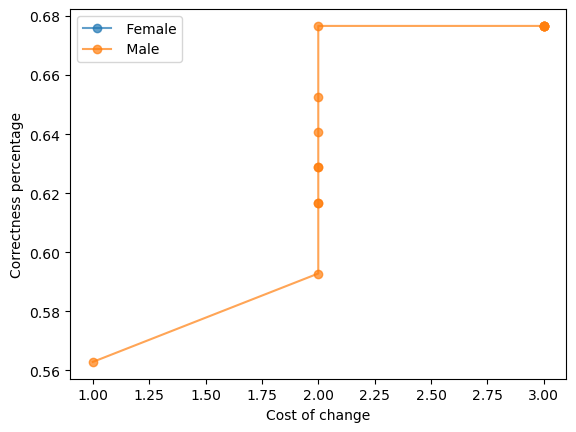

If Workclass =  Private, education-num = 9, occupation =  Exec-managerial:
	Protected Subgroup ' Female', 1.94% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.36% covered out of 32650
		Make education-num = 13 with correctness 59.18%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 58.16%.
		Make education-num = 13, occupation =  Sales with correctness 54.08%.
		Make education-num = 14 with correctness 62.24%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 62.24%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 58.16%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 62.24%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 64.29%.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 62.24%.
		Make Workclass =  Self-emp-not-inc, education-num = 15, occupation =  Prof-specialty with corr

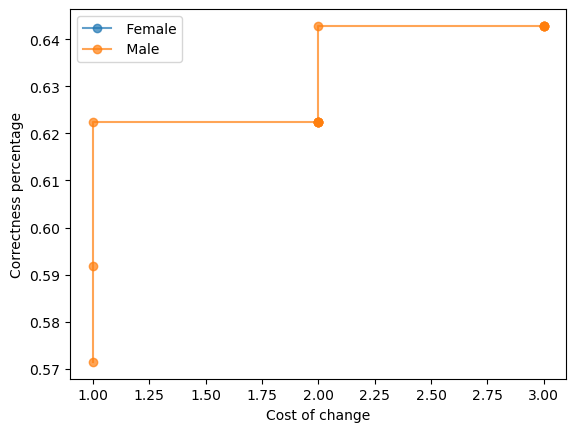

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 3.82% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.25% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 63.80%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 62.58%.
		Make education-num = 13 with correctness 57.67%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 65.03%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 63.80%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 63.19%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 65.64%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 68.10%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 64.42%.
		Make Workclass

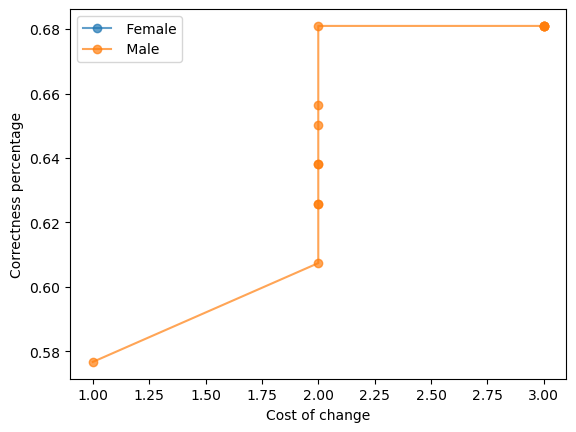

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 3.64% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.09% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 64.90%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 63.58%.
		Make education-num = 13 with correctness 58.94%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 66.23%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 64.90%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 64.24%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 66.89%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 65.56%.
		Make Workclass =  Local-gov, education-num = 13, occupation =  Prof-specialty wi

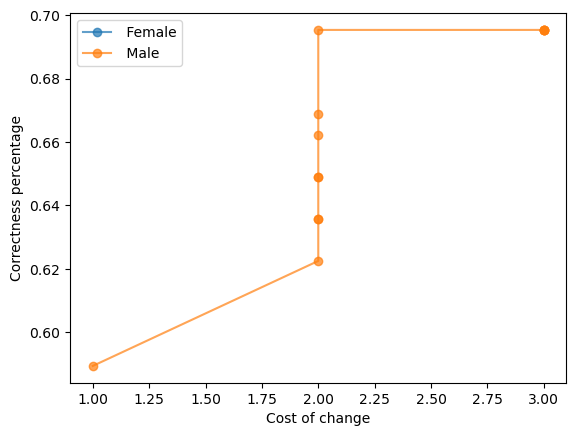

If Workclass =  Private, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.28% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.13% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 64.94%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 64.94%.
		Make education-num = 13 with correctness 60.39%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 66.23%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 64.94%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 64.94%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 67.53%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 65.58%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 70.13%.
		Make Workclass = 

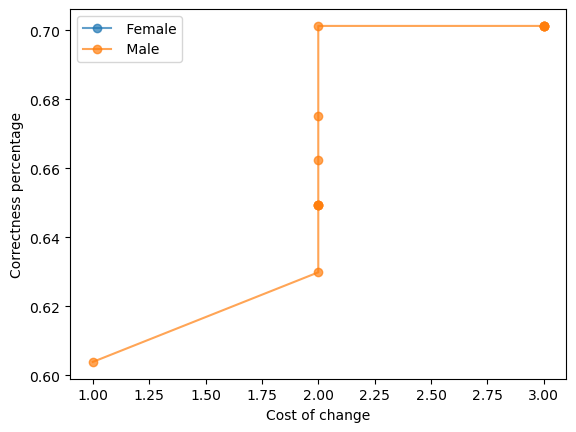

If Workclass =  Private, education-num = 9, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 2.37% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 4.88% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 56.66%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 55.81%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 58.36%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 57.22%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 56.37%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 59.77%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 62.04%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 57.79%.
		Make Workclass =  Self-emp-not-inc, education-num = 15, occupation =  P

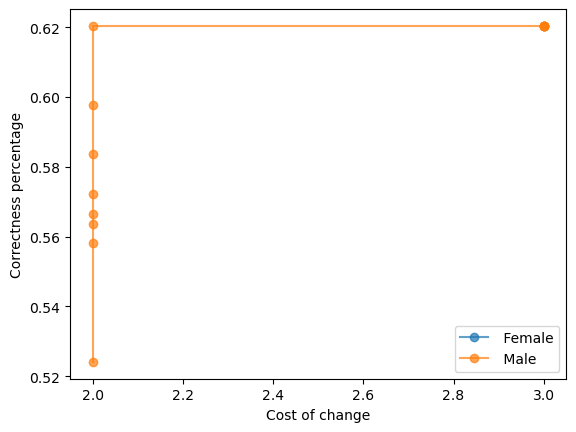

If Workclass =  ?, education-num = 9, occupation =  ?:
	Protected Subgroup ' Female', 2.30% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.80% covered out of 32650
		Make Workclass =  Private, education-num = 13, occupation =  Exec-managerial with correctness 58.46%.
		Make Workclass =  Private, education-num = 13, occupation =  Prof-specialty with correctness 56.15%.
		Make Workclass =  Private, education-num = 14, occupation =  Exec-managerial with correctness 62.31%.
		Make Workclass =  Private, education-num = 14, occupation =  Prof-specialty with correctness 61.54%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 57.69%.
		Make Workclass =  Private, education-num = 15, occupation =  Prof-specialty with correctness 63.08%.
		Make Workclass =  Private, education-num = 16, occupation =  Prof-specialty with correctness 66.15%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec

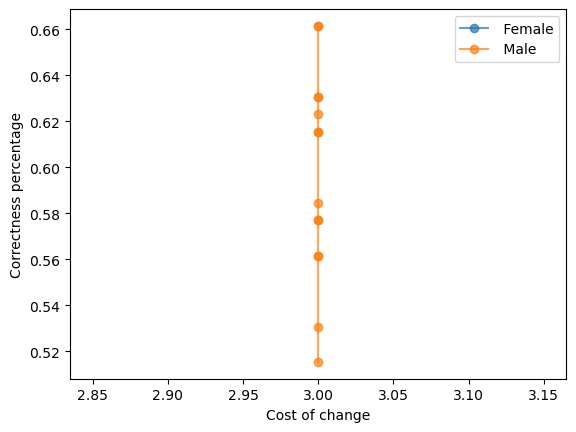

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 2.17% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 4.44% covered out of 32650
		Make education-num = 13, occupation =  Exec-managerial with correctness 58.26%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 57.94%.
		Make education-num = 13, occupation =  Sales with correctness 50.16%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 59.19%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 58.88%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 57.94%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 60.12%.
		Make Workclass =  Self-emp-inc, education-num = 13, occupation =  Exec-managerial with correctness 58.88%.
		Make Workclass =  Local-gov, education-num = 13

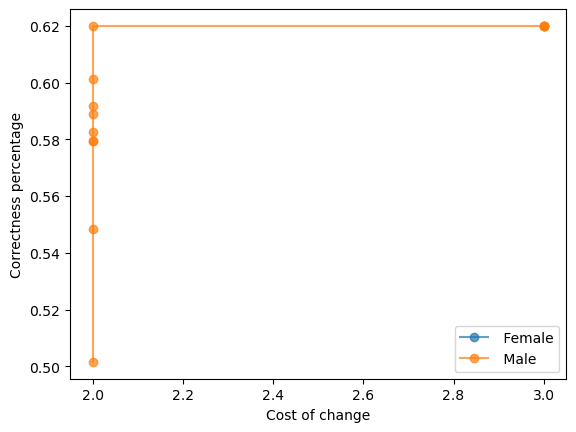

If Workclass =  Private, capital-loss = 0, education-num = 9, occupation =  Exec-managerial:
	Protected Subgroup ' Female', 1.92% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.34% covered out of 32650
		Make education-num = 13 with correctness 59.79%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 58.76%.
		Make education-num = 13, occupation =  Sales with correctness 54.64%.
		Make education-num = 14 with correctness 61.86%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 61.86%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 58.76%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 61.86%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 63.92%.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 61.86%.
		Make Workclass =  Self-emp-not-inc, education-num = 15, occupation =  Prof-s

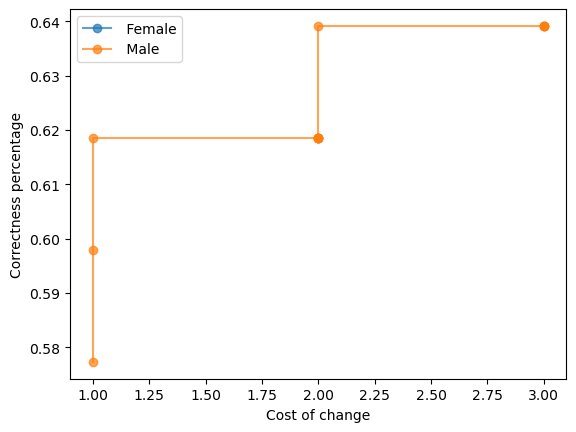

If Workclass =  Private, education-num = 9, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Female', 1.79% covered out of 16192
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.26% covered out of 32650
		Make education-num = 13 with correctness 60.44%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 59.34%.
		Make education-num = 13, occupation =  Sales with correctness 54.95%.
		Make education-num = 14 with correctness 61.54%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 61.54%.
		Make Workclass =  Local-gov, education-num = 14, occupation =  Prof-specialty with correctness 59.34%.
		Make education-num = 15, occupation =  Prof-specialty with correctness 61.54%.
		Make Workclass =  Self-emp-inc, education-num = 13 with correctness 61.54%.
		Make Workclass =  Local-gov, education-num = 13, occupation =  Prof-specialty with correctness 58.24%.
		Make Workclass =  Self-emp-not-inc, e

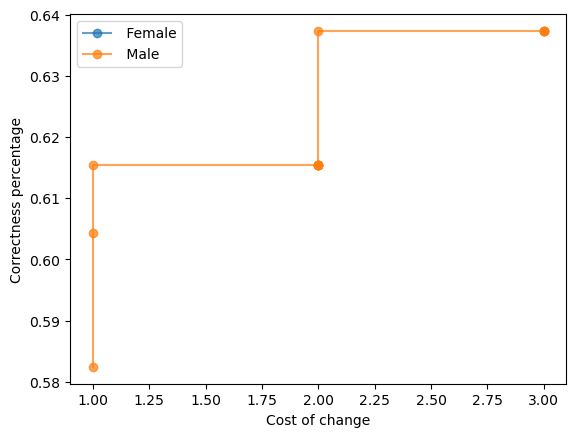

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex")

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [23]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)